In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import datetime
import math
import time
#from pandas.tseries.offsets import *
#from operator import *
from sklearn.cross_validation import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.cross_validation import TimeSeriesSplit
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
df_store = pd.read_csv("store.csv")
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [6]:
df_test.fillna(1,inplace=True)

In [7]:
df_store[df_store['CompetitionDistance'].isnull()]
CompetitionDistance_median= df_store['CompetitionDistance'].median()
df_store['CompetitionDistance'].fillna(CompetitionDistance_median,inplace=True)

In [8]:
df_store = pd.concat([df_store, pd.get_dummies(df_store['StoreType'],prefix='StoreType')], axis=1)
df_store = pd.concat([df_store, pd.get_dummies(df_store['Assortment'],prefix='Assortment') ], axis=1)

df_train['StateHoliday']=df_train['StateHoliday'].apply(lambda x:str(x))
df_train = pd.concat([df_train, pd.get_dummies(df_train['StateHoliday'],prefix='StateHoliday')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['StateHoliday'],prefix='StateHoliday')], axis=1)

df_test['StateHoliday_b']=0
df_test['StateHoliday_c']=0
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
Id                41088 non-null int64
Store             41088 non-null int64
DayOfWeek         41088 non-null int64
Date              41088 non-null object
Open              41088 non-null float64
Promo             41088 non-null int64
StateHoliday      41088 non-null object
SchoolHoliday     41088 non-null int64
StateHoliday_0    41088 non-null float64
StateHoliday_a    41088 non-null float64
StateHoliday_b    41088 non-null int64
StateHoliday_c    41088 non-null int64
dtypes: float64(3), int64(7), object(2)
memory usage: 3.8+ MB


In [9]:
def feature_engineering(df):
    
    #deal with the date information
    df['Date']=pd.to_datetime(df['Date'])
    df['Year']= df['Date'].dt.year
    df['Month']= df['Date'].dt.month
    df['Day']= df['Date'].dt.day
    df['WeekOfYear'] = df.Date.dt.weekofyear 

    df['CompetitionOpen']=(df['Year']-df["CompetitionOpenSinceYear"] )*12+(df['Month']-df["CompetitionOpenSinceMonth"])
    df['PromoOpen']=((df['Year']-df["Promo2SinceYear"] )*12+(df['WeekOfYear']-df["Promo2SinceWeek"])/4)
    
    df['CompetitionOpen'] = df.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    df['PromoOpen'] = df.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    month2str = {1:'Jan', 
                 2:'Feb', 
                 3:'Mar', 
                 4:'Apr', 
                 5:'May', 
                 6:'Jun', 
                 7:'Jul', 
                 8:'Aug', 
                 9:'Sept', 
                 10:'Oct', 
                 11:'Nov', 
                 12:'Dec'}
    
    df['Month2Str']=df['Month'].map(month2str)
    df.loc[df.PromoInterval.isnull() , 'PromoInterval'] = ''
    df['IsPromoMonth'] = 0
    for interval in df.PromoInterval.unique():
        if interval !='':
            for month in interval.split(','):
                df.loc[(df.Month2Str == month)&(df.PromoInterval == interval), 'IsPromoMonth'] = 1
    
    df.fillna(0,inplace=True)
    
    return df    

In [10]:
features_x = ['Store','CompetitionDistance','Year','Day','Month','WeekOfYear','DayOfWeek','Promo2','Promo',
           'SchoolHoliday','CompetitionOpen','PromoOpen','IsPromoMonth']
feature_y =['LogSales']

train = pd.merge(df_train, df_store, how='left', left_on='Store',right_on='Store')
test = pd.merge(df_test, df_store, how='left', left_on='Store',right_on='Store')

In [11]:
cat_features=(["StoreType_a","StoreType_b","StoreType_c","StoreType_d",'Assortment_a',
                 'Assortment_b','Assortment_c','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c'])

features_x = list(set(features_x + cat_features ))

In [12]:
train=feature_engineering(train)
test=feature_engineering(test)

In [13]:
train = train.sort_values(['Date'],ascending = False)
valid = train.loc[train['Date']>=datetime.datetime(2015,6,15)]  
train=train.loc[train['Date'] < datetime.datetime(2015,6,15)]
# only use data of Sales>0 and Open is 1
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]

In [14]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45852 entries, 0 to 51659
Data columns (total 37 columns):
Store                        45852 non-null int64
DayOfWeek                    45852 non-null int64
Date                         45852 non-null datetime64[ns]
Sales                        45852 non-null int64
Customers                    45852 non-null int64
Open                         45852 non-null int64
Promo                        45852 non-null int64
StateHoliday                 45852 non-null object
SchoolHoliday                45852 non-null int64
StateHoliday_0               45852 non-null float64
StateHoliday_a               45852 non-null float64
StateHoliday_b               45852 non-null float64
StateHoliday_c               45852 non-null float64
StoreType                    45852 non-null object
Assortment                   45852 non-null object
CompetitionDistance          45852 non-null float64
CompetitionOpenSinceMonth    45852 non-null float64
CompetitionOpenSi

In [15]:
def rmspe(y, yhat):    
    return np.sqrt(np.mean((yhat/y-1) ** 2)) 

def rmspe_xg(yhat, y):    
    y = np.expm1(y.get_label())    
    yhat = np.expm1(yhat)    
    return "rmspe", rmspe(y,yhat)

In [16]:
train['LogSales']=np.log1p(train['Sales'])
valid['LogSales']=np.log1p(valid['Sales'])

In [17]:
x_train, y_train = train[features_x], train[feature_y]
x_valid, y_valid = valid[features_x], valid[feature_y]

In [18]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_valid, y_valid)

In [19]:
num_round = 1000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [20]:
seed=10
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.04,
          "gamma":0,
          "max_depth":10,
          "subsample": 0.80, 
          "colsample_bytree": 0.6,
          "silent": 1, 
          "seed": 0,
          'nthread':8}

plst = params.items()

print("Train a XGBoost model")
start = time.time()

bst = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

end = time.time()
print('Training time is {:2f} s.'.format(end-start))

Train a XGBoost model
[0]	train-rmse:7.93699	test-rmse:7.96912	train-rmspe:0.999777	test-rmspe:0.999785
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[250]	train-rmse:0.171444	test-rmse:0.186562	train-rmspe:0.217724	test-rmspe:0.200144
[500]	train-rmse:0.118778	test-rmse:0.144225	train-rmspe:0.164306	test-rmspe:0.154456
[750]	train-rmse:0.100395	test-rmse:0.131123	train-rmspe:0.145418	test-rmspe:0.14026
[999]	train-rmse:0.091441	test-rmse:0.126057	train-rmspe:0.131167	test-rmspe:0.13499
Training time is 1012.640363 s.


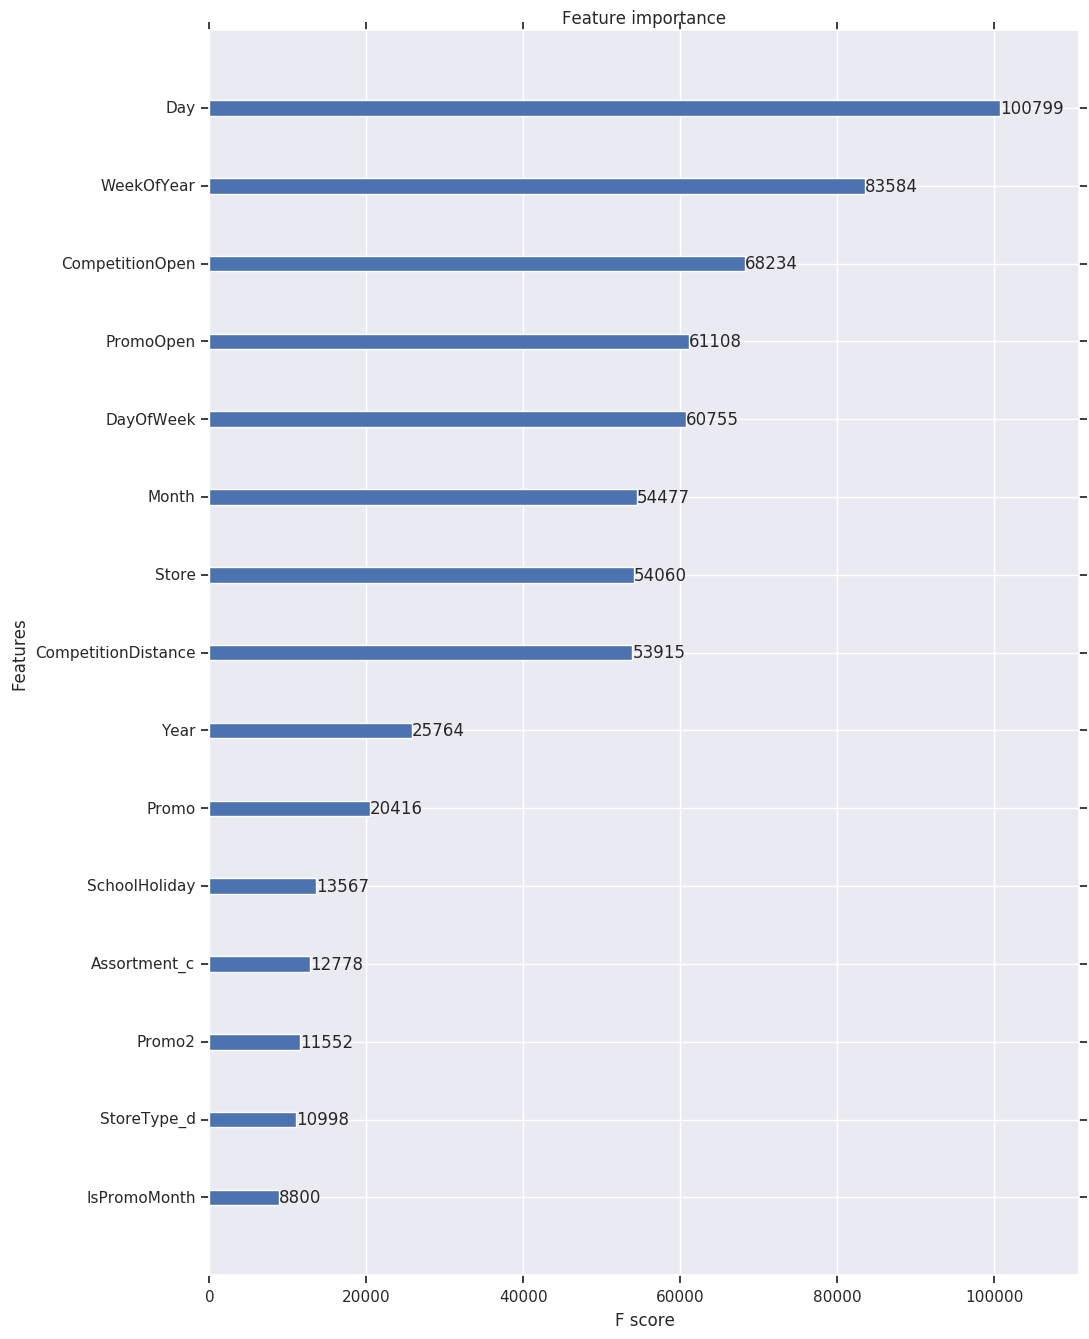

In [21]:
sns.set()
fig, ax = plt.subplots(figsize=(10, 15))
#fig, ax = plt.subplots(1,1,figsize=(15,8))
xgb.plot_importance(bst,ax=ax,max_num_features=15)

In [22]:
print("validating")

yhat = bst.predict(xgb.DMatrix(x_valid[features_x]))
error = rmspe(np.expm1(y_valid['LogSales']), np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

validating
RMSPE: 0.134990


weight correction
RMSPE for 0.990:0.139611
RMSPE for 0.991:0.136818
RMSPE for 0.992:0.134462
RMSPE for 0.993:0.132582
RMSPE for 0.994:0.131212
RMSPE for 0.995:0.130383
RMSPE for 0.996:0.130120
RMSPE for 0.997:0.130442
RMSPE for 0.998:0.131360
RMSPE for 0.999:0.132877
RMSPE for 1.000:0.134990
RMSPE for 1.001:0.137685
RMSPE for 1.002:0.140946
RMSPE for 1.003:0.144751
RMSPE for 1.004:0.149071
RMSPE for 1.005:0.153881
RMSPE for 1.006:0.159149
RMSPE for 1.007:0.164848
RMSPE for 1.008:0.170948
RMSPE for 1.009:0.177423
RMSPE for 1.010:0.184248
Best weight for Score:0.996    0.13012
dtype: float64


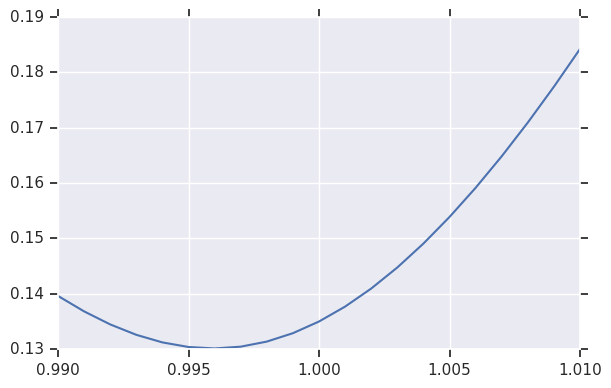

In [23]:
print("weight correction")
W=np.arange(0.99,1.01,0.001)
S =[]
for w in W:
    error = rmspe(np.expm1(y_valid['LogSales']), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [24]:
weights  = np.arange(0.99,1.01,0.001)
error  = {w :0 for w in weights}

In [25]:
res = pd.DataFrame(y_valid['LogSales'])
res['Prediction'] = yhat
res =pd.merge(x_valid,res,left_index =True,right_index=True)

res['Weights'] = 0
X_test = test[features_x]
X_test['Weights'] = 0

In [26]:
for i in range(1,1116):
   # s1 = X_valid.loc[X_valid['Store'] == i]
    #s2 = X_valid.loc[X_valid['Store' ]== i]
    for w in weights:
        error[w] = rmspe(np.expm1(res.loc[res['Store'] == i].LogSales),np.expm1(res.loc[res['Store'] == i].Prediction*w))
    w_best = min(error, key = error.get)
    res.loc[res['Store'] == i,'Weights'] = w_best
    X_test.loc[X_test['Store'] == i,'Weights']= w_best
X_test

,StateHoliday_a,Assortment_b,Month,DayOfWeek,Promo,Day,Promo2,WeekOfYear,StateHoliday_b,StoreType_d,...,CompetitionDistance,IsPromoMonth,StoreType_c,StateHoliday_c,StoreType_a,StateHoliday_0,Year,StoreType_b,PromoOpen,Weights
0,0.0,0.0,9,4,1,17,0,38,0,0.0,...,1270.0,0,1.0,0,0.0,1.0,2015,0.0,0.00,0.997
1,0.0,0.0,9,4,1,17,1,38,0,0.0,...,14130.0,0,0.0,0,1.0,1.0,2015,0.0,54.00,0.994
2,0.0,0.0,9,4,1,17,0,38,0,0.0,...,24000.0,0,0.0,0,1.0,1.0,2015,0.0,0.00,1.003
3,0.0,0.0,9,4,1,17,0,38,0,0.0,...,7520.0,0,0.0,0,1.0,1.0,2015,0.0,0.00,1.007
4,0.0,0.0,9,4,1,17,0,38,0,0.0,...,2030.0,0,0.0,0,1.0,1.0,2015,0.0,0.00,0.999
5,0.0,0.0,9,4,1,17,0,38,0,0.0,...,3160.0,0,0.0,0,1.0,1.0,2015,0.0,0.00,1.002
6,0.0,0.0,9,4,1,17,1,38,0,0.0,...,960.0,0,0.0,0,1.0,1.0,2015,0.0,45.25,0.994
7,0.0,0.0,9,4,1,17,1,38,0,0.0,...,1070.0,0,0.0,0,1.0,1.0,2015,0.0,66.25,0.996
8,0.0,0.0,9,4,1,17,1,38,0,1.0,...,310.0,0,0.0,0,0.0,1.0,2015,0.0,70.25,0.993
9,0.0,0.0,9,4,1,17,1,38,0,0.0,...,1300.0,0,0.0,0,1.0,1.0,2015,0.0,47.50,0.997


In [27]:
test_probs =  bst.predict(xgb.DMatrix(test[features_x]))
error1=  rmspe(np.expm1(res.LogSales),np.expm1(yhat))
print ('RMSPE  {:6f}'.format(error1))
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv('Xgboost_final_one.csv',index = False)

error_en = rmspe(np.expm1(res.LogSales),np.expm1(res.Prediction*res.Weights))
print ('RMSPE for weight corretion {:6f}'.format(error_en))
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs*X_test.Weights)})
result.to_csv("Xgboost_final_two.csv", index=False)

RMSPE  0.134990
RMSPE for weight corretion 0.118544


In [28]:
#reference: https://github.com/lotlucky/Rossman-Sales-Prediction-Xgboost-and-ensembel
weights  = np.arange(0.98,1.02,0.001)
error  = {w :0 for w in weights}

y_pre_matrix = np.zeros((len(res.index),10))
y_test_matrix = np.zeros((len(X_test.index),10))
for r in range(10):
    print('round {}:\n'.format(r))
    
    params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": r
          }
    
    num_boost_round = 600
    
    bst1 = xgb.train(params, dtrain, num_boost_round, evals=evallist, 
                    early_stopping_rounds=250, feval=rmspe_xg, verbose_eval=100)
    
    yhat = bst1.predict(xgb.DMatrix(x_valid[features_x]))
    
    res['Prediction_new'] = yhat
    
    for i in range(1,1116):
        for w in weights:
            error[w] = rmspe(np.expm1(res.loc[res['Store'] == i].LogSales),np.expm1(res.loc[res['Store'] == i].Prediction_new*w))
    
    w_best = min(error, key = error.get)
    res.loc[res['Store'] == i,'Weights'] = w_best
    X_test.loc[X_test['Store'] == i,'Weights']= w_best
    
    yhat_test = bst1.predict(xgb.DMatrix(test[features_x])) *X_test.Weights
    
    y_pre_matrix[:,r] = (res['Prediction_new'] * res['Weights']).tolist()
    y_test_matrix[:,r] = yhat_test.tolist()

round 0:

[0]	train-rmse:5.79333	test-rmse:5.81974	train-rmspe:0.996817	test-rmspe:0.996915
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[100]	train-rmse:0.100563	test-rmse:0.142085	train-rmspe:0.147361	test-rmspe:0.154186
[200]	train-rmse:0.082913	test-rmse:0.135732	train-rmspe:0.116977	test-rmspe:0.147365
[300]	train-rmse:0.074248	test-rmse:0.135022	train-rmspe:0.081136	test-rmspe:0.146124
[400]	train-rmse:0.06869	test-rmse:0.134699	train-rmspe:0.073153	test-rmspe:0.145863
[500]	train-rmse:0.064132	test-rmse:0.135106	train-rmspe:0.067382	test-rmspe:0.146368
Stopping. Best iteration:
[335]	train-rmse:0.072077	test-rmse:0.134596	train-rmspe:0.078572	test-rmspe:0.145617

round 1:

[0]	train-rmse:5.79225	test-rmse:5.82132	train-rmspe:0.996839	test-rmspe:0.996948
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improv

In [29]:
print ('Validating')
 
bagged_ho_preds1 = y_pre_matrix.mean(axis = 1)
error1 = rmspe(np.expm1(y_valid['LogSales']), np.expm1(bagged_ho_preds1))
print('RMSPE for mean: {:.6f}'.format(error1))

Validating
RMSPE for mean: 0.114445


In [30]:
print("Make predictions on the test set")
bagged_preds = y_test_matrix.mean(axis = 1)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("XGB_submission_final_1.csv", index=False)

Make predictions on the test set


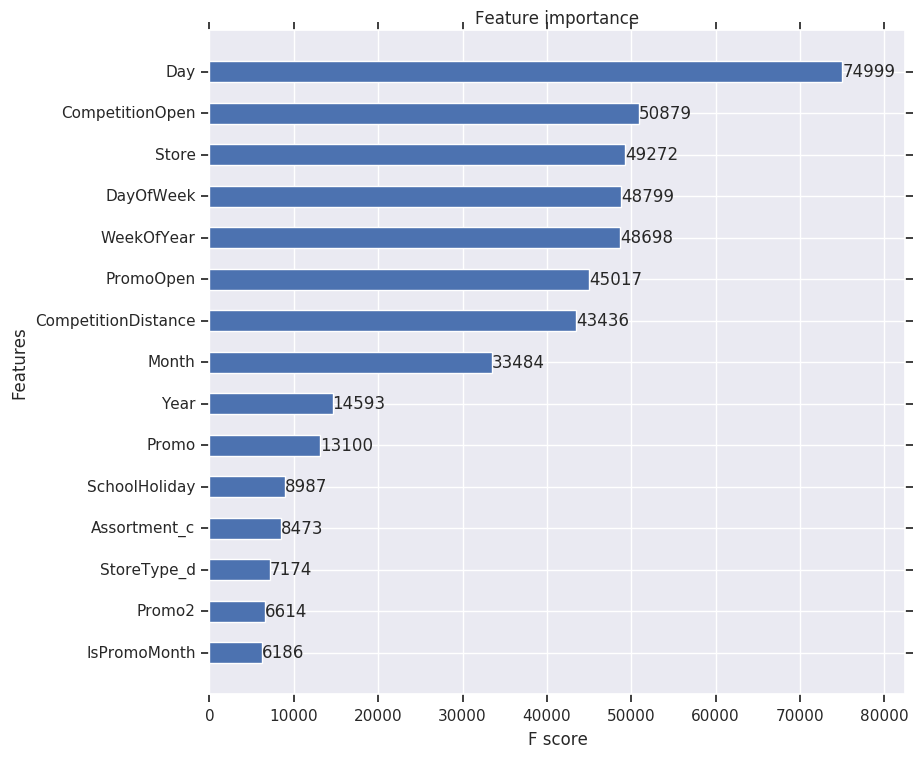

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(bst1, max_num_features= 15, height=0.5, ax=ax)
plt.show()